In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
%matplotlib inline

# Content

* [Intro](#topic1)
* [PyTorch vs TensoFlow](#topic2)
* [Goal](#topic3)
* [Creating a Custom Dataset](#topic4)
* [Load data](#topic5)
* [Create models](#topic6)
* [Train FCNN model](#topic7)
* [Train CNN model](#topic8)
* [Make predictions and submission file using CNN model](#topic9)

<a id =topic1> </a>
# **Intro**

💡 PyTorch is an open source machine learning framework that accelerates the path from research prototyping to production deployment. **It is used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).**

<a id =topic2> </a>
## **Comparation of PyTorch with TensorFlow and Keras.**

Based on the monthly number of Stack Overflow questions, we can see that PyTorch becomes more and more popular while TensorFlow and Keras are stagnating. This is one additional reason to get more familiar with this package.
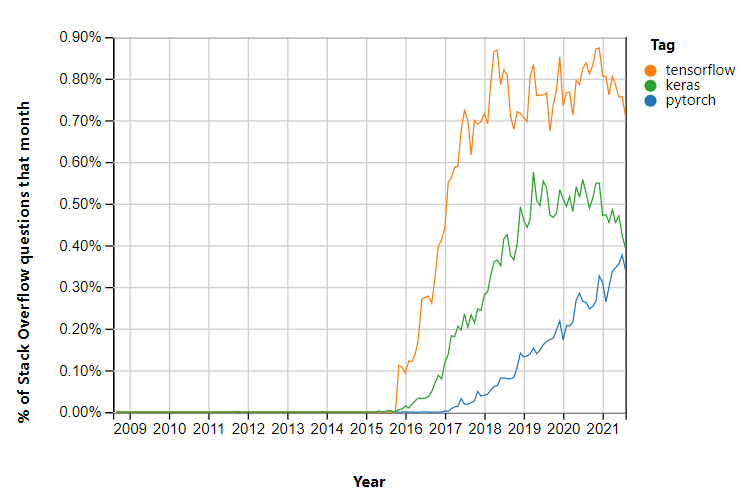
<center><i>Source: Stack Overflow</i></center>

Also, PyTorch is fast outpacing TensorFlow in research papers. Of 20-35% of conferene papers that mention the framework they use, **75% cite the use of PyTorch but not TensorFlow**.
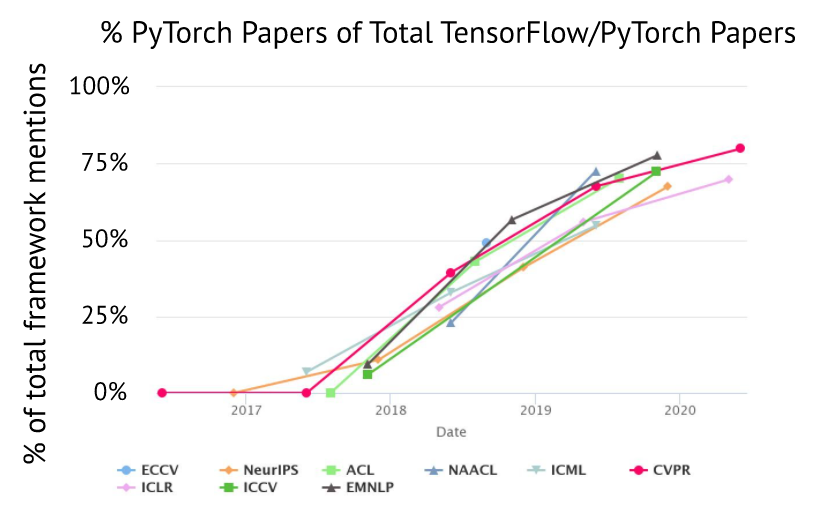
<center><i>Source: https://www.stateof.ai/</i></center>

PyTorch is also more popular that TensorFlow in paper implementations on GitHub. **58% of these implementations are based on Pytorch vs 13% for TensorFlow.**
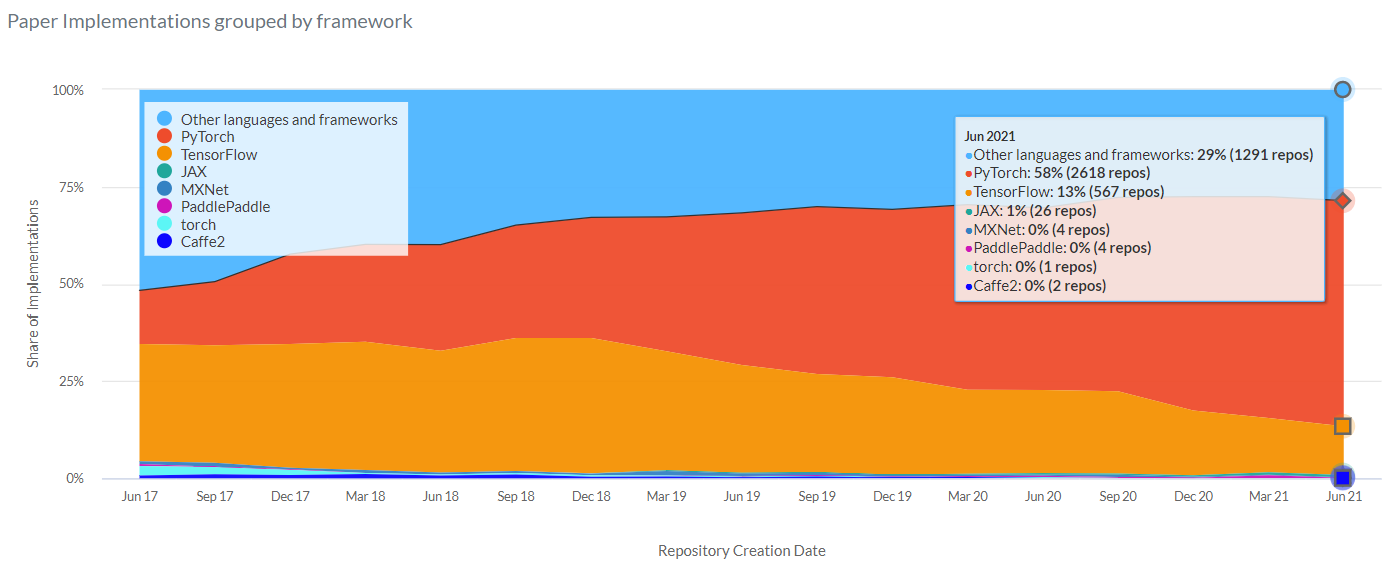
<center><i>Source: https://paperswithcode.com/trends</i></center>


<a id =topic3> </a>
# Goal

Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This tutorial introduces you to a complete ML workflow implemented in PyTorch. 

<a id =topic4> </a>
# Creating a Custom Dataset

`Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

Also, data set can be created using `torchvision.datasets.ImageFolder` where the images are arranged as
```
root/dog/xxx.png
...
root/cat/yyy.png
```

In [ ]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class CustomImageDataset(Dataset):
    def __init__(self, df, data_type = 'train', model_type='ffnn'):
        """
        :param df: data frame
        :param rating_2014_file: 'train'/'test'
        :param model_type: 'ffnn'/'cnn'
        """
        if data_type == 'train':
            self.X = df.drop('label', axis=1).values/255.
            self.Y = df['label'].values
        else:
            self.X = df.values/255.
            self.Y = None
        self.X = torch.from_numpy(self.X.astype(np.float32)).reshape(len(df),28, 28)
        self.data_type = data_type
        self.model_type = model_type

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.data_type == 'train':
            label = self.Y[idx]
        else:
            label = None
        
        if self.model_type == 'ffnn':
            return image, label
        else:
            # add additional dimension if we need dataset for cnn
            return image.unsqueeze(0), label

<a id =topic5> </a>
# Load data

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30

# load data
df = pd.read_csv('../input/digit-recognizer/train.csv')
df_train, df_val = train_test_split(df, test_size=0.2)

# create Dataset
training_data = CustomImageDataset(df_train)
val_data = CustomImageDataset(df_val)

# create Dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<a id =topic6> </a>
# Create models

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function.

We'll define **fully connected feed forward neural network** and **convolutional neural network**.

In [ ]:

# Define model, fully connected feed forward nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# convolutional nn
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # input torch.Size([64, 1, 28, 28])
        # torch.Size([batch_size, channels, img_width, img_height])
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4)
        # torch.Size([64, 16, 28-kernel_size+1, 28-kernel_size+1])
        # torch.Size([64, 16, 25, 25])
        self.relu1=nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2)
        
        # torch.Size([64, 8, 24, 24])
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=2)
        
        # torch.Size([64, 8, 12, 12])
        self.fc1 = nn.Linear(8*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        out=self.conv1(x)
        out=self.relu1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.max_pool2(out)
        
        out = torch.flatten(out, 1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

Also, we'll define EarlyStopping function that stops the training in case validation loss haven't decreased in the 5 consecutive epochs

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn, result_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    result_dict['avg_loss'].append(test_loss)
    result_dict['acc'].append(correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def plot_results(axs, res_dict):
    
    axs[0].plot(res_dict['epoch'][-10:], res_dict['acc'][-10:], c='r')
    axs[0].set_title('Validation accuracy {:.4f}'.format(res_dict['acc'][-1]))
    
    axs[1].plot(res_dict['epoch'][-10:], res_dict['avg_loss'][-10:], c='r')
    axs[1].set_title('Average validation loss {:.4f}'.format(res_dict['avg_loss'][-1]))
    display.clear_output(wait=True)
    display.display(plt.gcf())

<a id =topic7> </a>
# Train FCNN model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

model_fcnn = NeuralNetwork().to(device)
print(model_fcnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Fully connected neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_fcnn, loss_fn, optimizer)
    test(val_dataloader, model_fcnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

<a id =topic8> </a>
# Train CNN model

In [ ]:
# create Dataset for cnn
training_data = CustomImageDataset(df_train, model_type='cnn')
val_data = CustomImageDataset(df_val, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

model_cnn = CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn, loss_fn, optimizer)
    test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [ ]:
# save model
torch.save(model_cnn.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# load model
model = CNN()
model.load_state_dict(torch.load("model.pth"))

<a id =topic9> </a>
# Make predictions and submission file using CNN model

In [ ]:
# predictions

df_test = pd.read_csv('../input/digit-recognizer/test.csv')
test_data = CustomImageDataset(df_test, data_type = 'test', model_type='cnn')

# switch to evaluation, opposite to model.train()
model.eval()

with torch.no_grad():
    pred = model(test_data.X.unsqueeze(1))
    
pred = pred.argmax(axis=1)
df_sub = pd.DataFrame({'ImageId':list(range(1,len(pred)+1)), 'Label':pred})
df_sub.to_csv("cnn_mnist_submission.csv",index=False)